In [1]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
from tensorflow.keras.initializers import GlorotUniform


# Load data
p_data = np.load("pituitary_final.npy")
n_data = np.load("no_tumor_final.npy")
g_data = np.load("glioma_final.npy")
m_data = np.load("meningioma_final.npy")

# Set labels
p_labels = np.ones(p_data.shape[0], dtype=np.int32)*0
n_labels = np.ones(n_data.shape[0], dtype=np.int32)*1
g_labels = np.ones(g_data.shape[0], dtype=np.int32)*2
m_labels = np.ones(m_data.shape[0], dtype=np.int32)*3

all_data = np.concatenate([p_data, n_data, g_data, m_data], axis=0)
all_labels = np.concatenate([p_labels, n_labels, g_labels, m_labels])

# One-hot encode labels
one_hot_label = to_categorical(all_labels)

# Initialize k-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize list to store Test Accuracies
test_accs = []

# Initialize list to store Test Losses
test_losses = []


# # Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(4, (2, 2), activation='relu', kernel_initializer=GlorotUniform(),
                           input_shape=(64, 64, 4)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer=GlorotUniform()),
    tf.keras.layers.Dense(4, activation='softmax', kernel_initializer=GlorotUniform())
])

# Train and evaluate model using Stratified K Fold cross-validation

y_true_all = []
y_pred_all = []
for train_index, test_index in skf.split(all_data, all_labels):
    train_data, test_data = all_data[train_index], all_data[test_index]
    train_labels, test_labels = one_hot_label[train_index], one_hot_label[test_index]
    
    # Compile the model
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(train_data, train_labels, batch_size=32, epochs=20)

    # Evaluate the model
    test_loss, test_acc = model.evaluate(test_data,test_labels, verbose=1)
    print('Test accuracy:', test_acc)

    # Append test accuracy to list
    test_accs.append(test_acc)
    
    # Predict the test labels
    y_pred = np.argmax(model.predict(test_data), axis=-1)
    y_true = test_labels
    
    # Append true and predicted labels to lists
    y_true_all.extend(y_true)
    y_pred_all.extend(y_pred)

    test_losses.append(history.history['loss'][-1]) # append the final loss value of the last epoch to the list
    
    






Epoch 1/20
92/92 [==============================] - 7s 67ms/step - loss: 2.2879 - accuracy: 0.3327
Epoch 2/20
92/92 [==============================] - 7s 81ms/step - loss: 1.1172 - accuracy: 0.5305
Epoch 3/20
92/92 [==============================] - 6s 69ms/step - loss: 0.9912 - accuracy: 0.6078
Epoch 4/20
92/92 [==============================] - 8s 82ms/step - loss: 0.8673 - accuracy: 0.6534
Epoch 5/20
92/92 [==============================] - 6s 69ms/step - loss: 0.7906 - accuracy: 0.6953
Epoch 6/20
92/92 [==============================] - 8s 85ms/step - loss: 0.7481 - accuracy: 0.7177
Epoch 7/20
92/92 [==============================] - 7s 71ms/step - loss: 0.7025 - accuracy: 0.7286
Epoch 8/20
92/92 [==============================] - 8s 82ms/step - loss: 0.6411 - accuracy: 0.7647
Epoch 9/20
92/92 [==============================] - 6s 69ms/step - loss: 0.5803 - accuracy: 0.7947
Epoch 10/20
92/92 [==============================] - 7s 76ms/step - loss: 0.5439 - accuracy: 0.8086
Epoch 11/

In [30]:
# Average Test Accuracy
avg_acc = np.mean(test_accs)
print("Average test accuracy: {:.2f}%".format(avg_acc * 100))

#Average Loss
avg_loss = np.mean(test_losses)
print('Average loss:', avg_loss)



Average test accuracy: 96.94%
Average loss: 0.03573091863509035


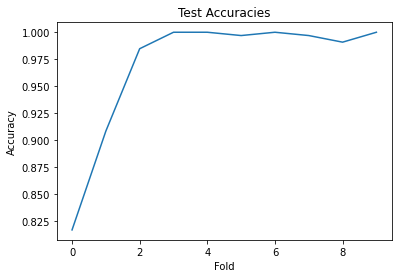

In [4]:

# Plot test accuracies
plt.plot(test_accs)
plt.title('Test Accuracies')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.show()

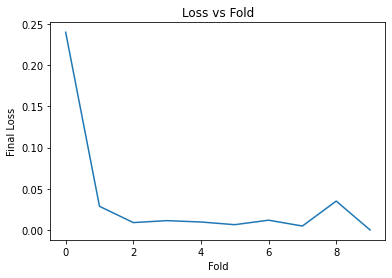

In [5]:
# Plot Loss accuracies
plt.plot(test_losses)
plt.title('Loss vs Fold')
plt.xlabel('Fold')
plt.ylabel('Final Loss')
plt.show()

Text(0.5, 1.0, 'Training Accuracy')

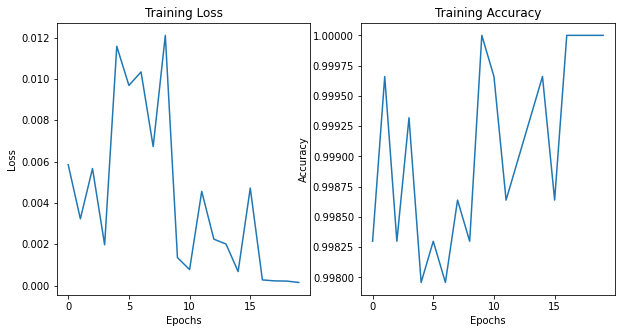

In [16]:
# Plot loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(history.history['loss'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')

ax[1].plot(history.history['accuracy'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training Accuracy')

11/11 [==============================] - 0s 35ms/step


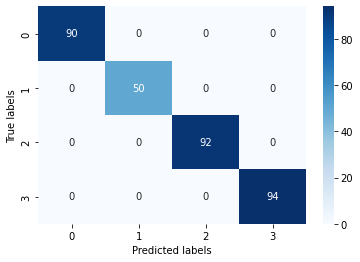

In [29]:
#Confusion Matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted labels for the test data
y_pred = np.argmax(model.predict(test_data), axis=1)

# Get the true labels for the test data
y_true = np.argmax(test_labels, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

                  precision    recall  f1-score   support

 Pituitary Tumor       1.00      1.00      1.00        90
        No Tumor       1.00      1.00      1.00        50
    Glioma Tumor       1.00      1.00      1.00        92
Meningioma Tumor       1.00      1.00      1.00        94

        accuracy                           1.00       326
       macro avg       1.00      1.00      1.00       326
    weighted avg       1.00      1.00      1.00       326



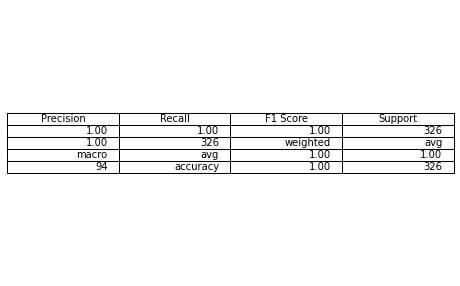

In [31]:
#Classification Report - Calculates the Macro precision, Macro recall, Macro F1 Score, and Support
#of each class to facilitate observation, where support refers to the number of original real data belonging to this class

from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

fig, ax = plt.subplots(figsize=(8, 5))
ax.axis('off')
ax.axis('tight')
ax.table(cellText=[report.split()[-4:], report.split()[-8:-4], report.split()[-12:-8], report.split()[-16:-12]],
colLabels=['Precision', 'Recall', 'F1 Score', 'Support'], loc='center')
plt.show()